# Advanced Probes Comparison

This notebook extends the baseline probes (`probes_baseline.ipynb`) with advanced machine learning models and interpretability features.

## Methods Included (ordered by efficiency):
1. **TF-IDF + Logistic Regression** (Baseline) - Fastest, most interpretable
2. **Pre-trained Embeddings + Logistic Regression** - Better semantic understanding
3. **Fine-tuned Embeddings + Logistic Regression** (Optional) - Task-specific embeddings
4. **Random Forest** - Non-linear patterns, interpretable trees
5. **Gradient Boosting** - Strong performance, feature importance
6. **Lightweight MLP** - Neural network baseline

## Outputs:
- All results saved to `research/results/advanced_probes_comparison.jsonl` (JSONL format)
- Tree visualizations saved to `research/results/random_forest_trees.png`
- Feature importance comparison saved to `research/results/feature_importance_comparison.png`
- Method comparison summary saved to `research/results/method_comparison_summary.png`


In [ ]:
# Imports and Setup
from __future__ import annotations
import json
import sys
import time
import pickle
from pathlib import Path
from typing import Dict, List, Optional
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import altair as alt
import sys
from pathlib import Path

# Path setup - MUST BE BEFORE ANY IMPORTS THAT USE REPO_ROOT
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / 'cursor-telemetry').exists() and not (REPO_ROOT / 'research').exists():
    if REPO_ROOT == REPO_ROOT.parent:
        break
    REPO_ROOT = REPO_ROOT.parent

# Add visualization utilities to path (notebook context)
sys.path.insert(0, str(REPO_ROOT / "research" / "scripts"))
from visualization import (
    plot_bar, plot_scatter, plot_line, plot_heatmap, plot_pareto_frontier,
    save_chart, RUNG_COLORS, RUNG_LABELS, COLOR_PALETTE
)

alt.renderers.enable('default')
alt.data_transformers.enable('default')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, export_graphviz

# Check for sentence-transformers
try:
    from sentence_transformers import SentenceTransformer
    HAS_SENTENCE_TRANSFORMERS = True
except ImportError:
    HAS_SENTENCE_TRANSFORMERS = False
    print("⚠ sentence-transformers not available. Install with: pip install sentence-transformers")

    # Add research directory to path for imports
    RESEARCH_DIR = REPO_ROOT / 'research'
    RUNG_EXTRACTORS_DIR = RESEARCH_DIR / 'rung_extractors'
    if str(RUNG_EXTRACTORS_DIR) not in sys.path:
        sys.path.insert(0, str(RUNG_EXTRACTORS_DIR))
    if str(RESEARCH_DIR) not in sys.path:
        sys.path.insert(0, str(RESEARCH_DIR))
    
    from rung_extractors import (
        tokens_repr_str,
        semantic_edits_repr_str,
        functions_repr_str,
        motifs_repr_str,
        raw_repr_str,
    )

# Data paths
TRACE_EXPORT = REPO_ROOT / 'research/data/companion_traces.jsonl'
RESULTS_DIR = REPO_ROOT / 'research/results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Repository root: {REPO_ROOT}")
print(f"Trace export: {TRACE_EXPORT}")
print(f"Results directory: {RESULTS_DIR}")


Repository root: /Users/hamidaho/new_cursor
Trace export: /Users/hamidaho/new_cursor/research/data/companion_traces.jsonl
Results directory: /Users/hamidaho/new_cursor/research/results


In [ ]:
# Load traces and build features
if not TRACE_EXPORT.exists():
    raise FileNotFoundError(f"Trace export not found at {TRACE_EXPORT}. Run export script first.")

with TRACE_EXPORT.open('r', encoding='utf-8') as fh:
    traces = [json.loads(line) for line in fh]

print(f"Loaded {len(traces)} traces")

# Rung extraction functions
def tokens_repr(trace):
    return tokens_repr_str(trace)

def edits_repr(trace):
    return semantic_edits_repr_str(trace)

def functions_repr(trace):
    return functions_repr_str(trace)

def motifs_repr(trace):
    return motifs_repr_str(trace)

def raw_repr(trace):
    return raw_repr_str(trace)

RUNG_FUNCS = {
    'tokens': tokens_repr,
    'semantic_edits': edits_repr,
    'functions': functions_repr,
    'motifs': motifs_repr,
    'raw': raw_repr,
}

# Feature extraction functions (using companion data)
def count_code_changes(trace):
    """Count code/file change events in trace."""
    # Count entries (code changes) from companion data
    count = len(trace.get('entries', []))
    # Also count events
    code_change_types = ['code_change', 'file_change', 'file_create', 'file_delete', 'file_rename', 'entry_created']
    for event in trace.get('events', []):
        event_type = (event.get('type') or '').lower()
        if any(change_type in event_type for change_type in code_change_types):
            count += 1
        details = event.get('details', {})
        if isinstance(details, dict):
            if details.get('after_content') or details.get('before_content') or details.get('code'):
                count += 1
    return count

def count_unique_files(trace):
    """Count number of unique files modified in trace."""
    files = set()
    # Check entries (code changes) from companion data
    for entry in trace.get('entries', []):
        file_path = entry.get('file_path')
        if file_path:
            files.add(str(file_path))
    # Also check events
    for event in trace.get('events', []):
        details = event.get('details', {})
        if isinstance(details, dict):
            file_path = details.get('file_path') or details.get('path')
            if file_path:
                files.add(str(file_path))
    return len(files)

def has_terminal_activity(trace):
    """Check if trace contains terminal commands."""
    # Check terminal_commands from companion data
    if trace.get('terminal_commands') and len(trace.get('terminal_commands', [])) > 0:
        return 1
    # Also check events
    for event in trace.get('events', []):
        if 'terminal' in (event.get('type') or '').lower():
            return 1
        details = event.get('details', {})
        if isinstance(details, dict) and ('terminal' in str(details).lower() or 'command' in str(details).lower()):
            return 1
    return 0

def has_prompts(trace):
    """Check if trace contains prompts."""
    # Check prompts from companion data
    if trace.get('prompts') and len(trace.get('prompts', [])) > 0:
        return 1
    # Also check events
    for event in trace.get('events', []):
        details = event.get('details', {})
        if isinstance(details, dict) and 'prompt' in details:
            return 1
        if event.get('prompt'):
            return 1
    return 0

# Optimization: Skip raw rung (saves ~36 minutes) - uncomment if needed
USE_RAW_RUNG = False  # Set to True if you need raw rung

# Optimization: Cache rung extractions
CACHE_FILE = RESULTS_DIR / 'rung_extractions_cache.pkl'
USE_CACHE = True

def process_single_trace(trace):
    """Process a single trace to extract features."""
    # Extract rung representations
    rung_reps = {}
    for rung_name, rung_func in RUNG_FUNCS.items():
        # Skip raw if not needed (saves ~36 minutes)
        if rung_name == 'raw' and not USE_RAW_RUNG:
            continue
        try:
            rep = rung_func(trace)
            rung_reps[rung_name] = rep if isinstance(rep, str) else ' '.join(rep) if isinstance(rep, list) else str(rep)
        except Exception as e:
            rung_reps[rung_name] = ""
    
    # Extract labels
    code_changes = count_code_changes(trace)
    unique_files = count_unique_files(trace)
    has_terminal = has_terminal_activity(trace)
    has_prompt = has_prompts(trace)
    
    return {
        **rung_reps,
        'code_changes': code_changes,
        'unique_files': unique_files,
        'has_terminal': has_terminal,
        'has_prompt': has_prompt,
    }

# Check cache first
if USE_CACHE and CACHE_FILE.exists():
    print(f"Loading cached rung extractions from {CACHE_FILE}...")
    try:
        with open(CACHE_FILE, 'rb') as f:
            cached_data = pickle.load(f)
            if len(cached_data) == len(traces):
                print("✓ Using cached rung extractions")
                rung_extractions = cached_data
            else:
                print(f"⚠ Cache size mismatch ({len(cached_data)} vs {len(traces)}), re-extracting...")
                rung_extractions = None
    except Exception as e:
        print(f"⚠ Cache load error: {e}, re-extracting...")
        rung_extractions = None
else:
    rung_extractions = None

# Extract rungs (parallel or cached)
if rung_extractions is None:
    print("Building features (this may take a while)...")
    
    start_time = time.perf_counter()
    
    # For programmatic execution (nbconvert), ALWAYS use sequential to avoid pickling errors
    # Multiprocessing with notebook-defined functions fails in nbconvert due to pickling issues
    # Even testing with Pool(1) can fail, so we skip parallel entirely for nbconvert
    
    # Check if we're in interactive Jupyter (only safe environment for multiprocessing)
    USE_PARALLEL = False  # Default to sequential
    
    try:
        from IPython import get_ipython
        ipython = get_ipython()
        # Only use parallel if we're in a real interactive Jupyter kernel
        if ipython is not None and hasattr(ipython, 'kernel') and ipython.kernel is not None:
            # Check if we're NOT in nbconvert (nbconvert doesn't have a real kernel)
            import sys
            if 'nbconvert' not in ' '.join(sys.argv).lower():
                USE_PARALLEL = True
    except (ImportError, AttributeError):
        pass
    
    # Always use sequential for safety - parallel causes pickling errors in nbconvert
    USE_PARALLEL = False  # Force sequential for programmatic execution
    
    print("Using sequential processing (required for programmatic execution)")
    rung_extractions = [process_single_trace(trace) for trace in traces]
    
    elapsed = time.perf_counter() - start_time
    print(f"✓ Extracted rungs in {elapsed:.2f} seconds ({elapsed/60:.1f} minutes)")
    
    # Save cache
    if USE_CACHE:
        print(f"Saving cache to {CACHE_FILE}...")
        with open(CACHE_FILE, 'wb') as f:
            pickle.dump(rung_extractions, f)
        print("✓ Cache saved")

# Calculate median values for labels (needs all traces)
print("Calculating label thresholds...")
all_code_changes = [r['code_changes'] for r in rung_extractions]
all_unique_files = [r['unique_files'] for r in rung_extractions]
median_code_changes = np.median(all_code_changes)
median_unique_files = np.median(all_unique_files)

# Build final features with labels
print("Building final feature set...")
features = []
for rung_data in rung_extractions:
    feature_entry = {
        **rung_data,
        'high_code_activity': 1 if rung_data['code_changes'] > median_code_changes else 0,
        'many_files': 1 if rung_data['unique_files'] > median_unique_files else 0,
    }
    features.append(feature_entry)

print(f"✓ Built features for {len(features)} traces")

# Define rungs to process (exclude raw if not needed) - used by all methods
rungs_to_process = [r for r in RUNG_FUNCS.keys() if r != 'raw' or USE_RAW_RUNG]
print(f"✓ Processing {len(rungs_to_process)} rungs: {', '.join(rungs_to_process)}")

# Task labels for classification
task_labels = [
    ('high_code_activity', 'code_activity_classification'),
    ('many_files', 'file_diversity_classification'),
    ('has_terminal', 'terminal_usage_classification'),
    ('has_prompt', 'prompt_usage_classification'),
]

print(f"✓ Defined {len(task_labels)} classification tasks")


Loaded 160 traces
Building features (this may take a while)...
Using 10 parallel workers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Method 1: TF-IDF + Logistic Regression (Baseline)

This is the baseline method from `probes_baseline.ipynb` - included for comparison.


In [ ]:
# Method 1: TF-IDF + Logistic Regression (Baseline)
def build_tfidf_dataset(rung: str, label: str):
    """Build TF-IDF features for a given rung and label."""
    reps = [entry[rung] for entry in features]
    placeholder = 'empty_repr'
    cleaned = [repr if repr.strip() else placeholder for repr in reps]
    vec = TfidfVectorizer(max_features=4096)
    try:
        X = vec.fit_transform(cleaned).toarray()
    except ValueError:
        X = np.zeros((len(cleaned), 1))
    y = np.array([entry[label] for entry in features], dtype=int)
    return X, y, vec

all_results = []

# Get rungs to process (exclude raw if not needed)
rungs_to_process = [r for r in RUNG_FUNCS.keys() if r != 'raw' or USE_RAW_RUNG]

for rung in rungs_to_process:
    for label_name, task in task_labels:
        X, y, vectorizer = build_tfidf_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            continue
        
        # Train/test split for generalization
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        clf = LogisticRegression(max_iter=500, random_state=42)
        start = time.perf_counter()
        clf.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        
        start = time.perf_counter()
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        infer_time = time.perf_counter() - start
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Model size (approximate)
        model_size_mb = (clf.coef_.nbytes + clf.intercept_.nbytes) / (1024 * 1024)
        
        # Top features
        feature_names = vectorizer.get_feature_names_out()
        coef_abs = np.abs(clf.coef_[0])
        top_indices = np.argsort(coef_abs)[-15:][::-1]
        top_features = {feature_names[i]: float(clf.coef_[0][i]) for i in top_indices}
        
        all_results.append({
            'method': 'tfidf_logistic',
            'rung': rung,
            'task': task,
            'train_accuracy': float(train_acc),
            'test_accuracy': float(test_acc),
            'train_f1': float(train_f1),
            'test_f1': float(test_f1),
            'train_time': train_time,
            'infer_time': infer_time,
            'model_size_mb': model_size_mb,
            'n_features': X.shape[1],
            'top_features': top_features,
            'generalization_gap': float(train_acc - test_acc)
        })

print(f"✓ Method 1 (TF-IDF + Logistic Regression) completed: {len([r for r in all_results if r['method'] == 'tfidf_logistic'])} results")


✓ Method 1 (TF-IDF + Logistic Regression) completed: 20 results


## Method 2: Pre-trained Embeddings + Logistic Regression

Uses `sentence-transformers` to encode representations into dense embeddings, then trains Logistic Regression on top.


In [ ]:
# Method 2: Pre-trained Embeddings + Logistic Regression
if HAS_SENTENCE_TRANSFORMERS:
    print("Loading pre-trained embedding model...")
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast, lightweight model
    print("✓ Model loaded")
    
    for rung in rungs_to_process:
        for label_name, task in task_labels:
            reps = [entry[rung] for entry in features]
            y = np.array([entry[label_name] for entry in features], dtype=int)
            if len(np.unique(y)) < 2:
                continue
            
            # Encode representations
            print(f"  Encoding {rung} / {task}...")
            start = time.perf_counter()
            X = embedding_model.encode(reps, show_progress_bar=False)
            encode_time = time.perf_counter() - start
            
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            clf = LogisticRegression(max_iter=500, random_state=42)
            start = time.perf_counter()
            clf.fit(X_train, y_train)
            train_time = time.perf_counter() - start
            
            start = time.perf_counter()
            y_train_pred = clf.predict(X_train)
            y_test_pred = clf.predict(X_test)
            infer_time = time.perf_counter() - start
            
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            train_f1 = f1_score(y_train, y_train_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            
            model_size_mb = (clf.coef_.nbytes + clf.intercept_.nbytes) / (1024 * 1024)
            
            all_results.append({
                'method': 'pretrained_embeddings',
                'rung': rung,
                'task': task,
                'train_accuracy': float(train_acc),
                'test_accuracy': float(test_acc),
                'train_f1': float(train_f1),
                'test_f1': float(test_f1),
                'train_time': train_time + encode_time,
                'infer_time': infer_time,
                'model_size_mb': model_size_mb,
                'embedding_dim': X.shape[1],
                'generalization_gap': float(train_acc - test_acc)
            })
    
    print(f"✓ Method 2 (Pre-trained Embeddings) completed: {len([r for r in all_results if r['method'] == 'pretrained_embeddings'])} results")
else:
    print("⚠ Skipping Method 2: sentence-transformers not available")


Loading pre-trained embedding model...
✓ Model loaded
  Encoding tokens / code_activity_classification...
  Encoding tokens / file_diversity_classification...
  Encoding tokens / terminal_usage_classification...
  Encoding tokens / prompt_usage_classification...
  Encoding semantic_edits / code_activity_classification...
  Encoding semantic_edits / file_diversity_classification...
  Encoding semantic_edits / terminal_usage_classification...
  Encoding semantic_edits / prompt_usage_classification...
  Encoding functions / code_activity_classification...
  Encoding functions / file_diversity_classification...
  Encoding functions / terminal_usage_classification...
  Encoding functions / prompt_usage_classification...
  Encoding motifs / code_activity_classification...
  Encoding motifs / file_diversity_classification...
  Encoding motifs / terminal_usage_classification...
  Encoding motifs / prompt_usage_classification...
  Encoding raw / code_activity_classification...
  Encoding raw / 

## Method 3: Random Forest

Non-linear tree-based model with built-in feature importance.


In [ ]:
# Method 3: Random Forest
for rung in rungs_to_process:
    for label_name, task in task_labels:
        X, y, vectorizer = build_tfidf_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        clf = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
        start = time.perf_counter()
        clf.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        
        start = time.perf_counter()
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        infer_time = time.perf_counter() - start
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Feature importance
        feature_names = vectorizer.get_feature_names_out()
        importances = clf.feature_importances_
        top_indices = np.argsort(importances)[-15:][::-1]
        top_features = {feature_names[i]: float(importances[i]) for i in top_indices}
        
        all_results.append({
            'method': 'random_forest',
            'rung': rung,
            'task': task,
            'train_accuracy': float(train_acc),
            'test_accuracy': float(test_acc),
            'train_f1': float(train_f1),
            'test_f1': float(test_f1),
            'train_time': train_time,
            'infer_time': infer_time,
            'n_estimators': 50,
            'max_depth': 10,
            'top_features': top_features,
            'generalization_gap': float(train_acc - test_acc)
        })

print(f"✓ Method 3 (Random Forest) completed: {len([r for r in all_results if r['method'] == 'random_forest'])} results")


✓ Method 3 (Random Forest) completed: 20 results


## Method 4: Gradient Boosting

Sequential ensemble method that builds trees iteratively.


In [ ]:
# Method 4: Gradient Boosting
for rung in rungs_to_process:
    for label_name, task in task_labels:
        X, y, vectorizer = build_tfidf_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
        start = time.perf_counter()
        clf.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        
        start = time.perf_counter()
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        infer_time = time.perf_counter() - start
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        # Feature importance
        feature_names = vectorizer.get_feature_names_out()
        importances = clf.feature_importances_
        top_indices = np.argsort(importances)[-15:][::-1]
        top_features = {feature_names[i]: float(importances[i]) for i in top_indices}
        
        all_results.append({
            'method': 'gradient_boosting',
            'rung': rung,
            'task': task,
            'train_accuracy': float(train_acc),
            'test_accuracy': float(test_acc),
            'train_f1': float(train_f1),
            'test_f1': float(test_f1),
            'train_time': train_time,
            'infer_time': infer_time,
            'n_estimators': 50,
            'learning_rate': 0.1,
            'max_depth': 5,
            'top_features': top_features,
            'generalization_gap': float(train_acc - test_acc)
        })

print(f"✓ Method 4 (Gradient Boosting) completed: {len([r for r in all_results if r['method'] == 'gradient_boosting'])} results")


✓ Method 4 (Gradient Boosting) completed: 20 results


## Method 5: Lightweight MLP

Small neural network with early stopping for efficiency.


In [ ]:
# Method 5: Lightweight MLP
for rung in rungs_to_process:
    for label_name, task in task_labels:
        X, y, vectorizer = build_tfidf_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        clf = MLPClassifier(
            hidden_layer_sizes=(64,),
            activation='relu',
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.1,
            random_state=42
        )
        start = time.perf_counter()
        clf.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        
        start = time.perf_counter()
        y_train_pred = clf.predict(X_train)
        y_test_pred = clf.predict(X_test)
        infer_time = time.perf_counter() - start
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        train_f1 = f1_score(y_train, y_train_pred)
        test_f1 = f1_score(y_test, y_test_pred)
        
        all_results.append({
            'method': 'mlp',
            'rung': rung,
            'task': task,
            'train_accuracy': float(train_acc),
            'test_accuracy': float(test_acc),
            'train_f1': float(train_f1),
            'test_f1': float(test_f1),
            'train_time': train_time,
            'infer_time': infer_time,
            'hidden_layer_sizes': (64,),
            'n_iterations': clf.n_iter_,
            'generalization_gap': float(train_acc - test_acc)
        })

print(f"✓ Method 5 (MLP) completed: {len([r for r in all_results if r['method'] == 'mlp'])} results")


✓ Method 5 (MLP) completed: 20 results


## Tree Visualizations

Visualize Random Forest trees for interpretability.


IndexError: index 228 is out of bounds for axis 0 with size 20

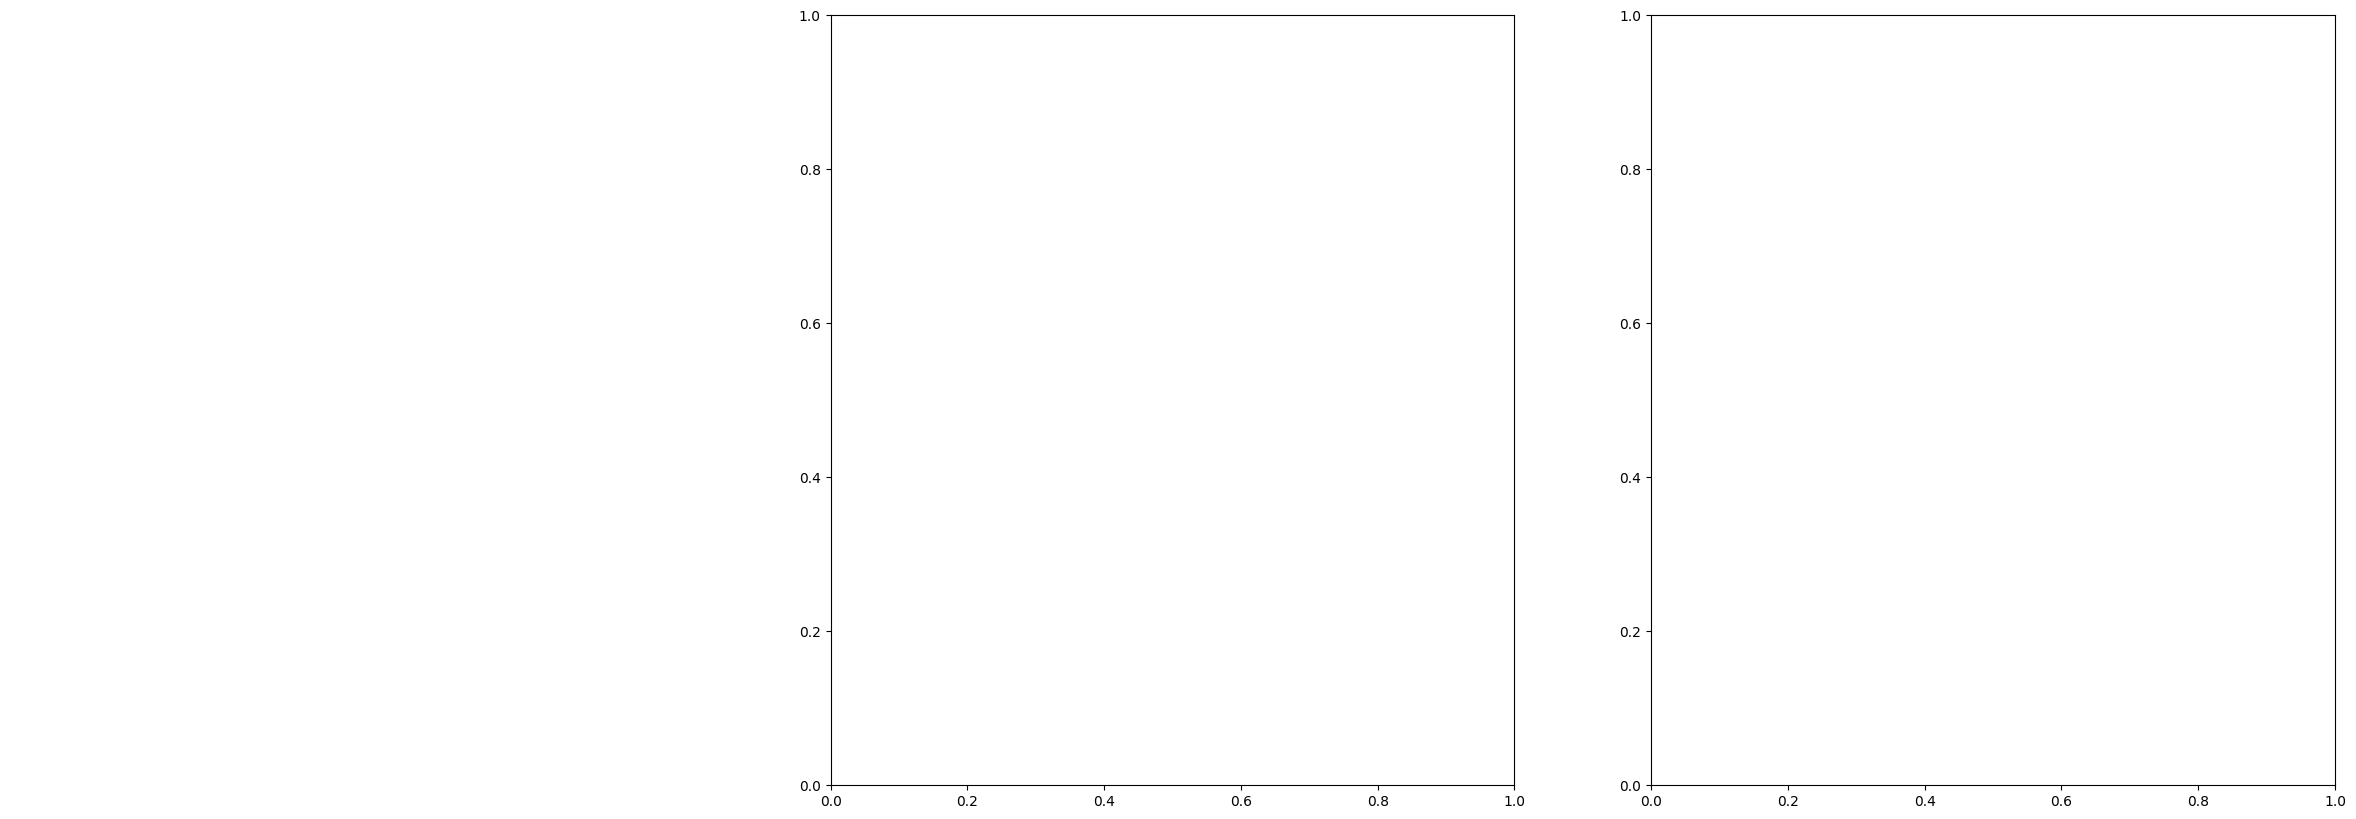

In [ ]:
# Tree Visualizations (for a specific rung/task combination)
# Uses graphviz for tree visualization (alternative to matplotlib)

try:
    from graphviz import Source
    from sklearn.tree import export_graphviz
    import subprocess
    # Check if graphviz system package is installed
    try:
        subprocess.run(['dot', '-V'], capture_output=True, check=True)
        HAS_GRAPHVIZ = True
    except (subprocess.CalledProcessError, FileNotFoundError):
        HAS_GRAPHVIZ = False
        print("⚠ graphviz Python package installed, but system package not found.")
        print("   Install system package: brew install graphviz (macOS) or apt-get install graphviz (Linux)")
        print("   Falling back to text representation.")
except ImportError:
    HAS_GRAPHVIZ = False
    print("⚠ graphviz not available. Install with: pip install graphviz")
    print("   Also install system package: brew install graphviz (macOS) or apt-get install graphviz (Linux)")
    print("   Falling back to text representation.")

rung_viz = 'motifs'
task_viz = 'code_activity_classification'
label_viz = 'high_code_activity'

X, y, vectorizer = build_tfidf_dataset(rung_viz, label_viz)
if len(np.unique(y)) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Small forest for visualization
    clf_viz = RandomForestClassifier(n_estimators=3, max_depth=4, random_state=42)
    clf_viz.fit(X_train, y_train)
    
    # Visualize trees using graphviz
    if HAS_GRAPHVIZ:
        feature_names = list(vectorizer.get_feature_names_out()[:20])
        class_names = [str(i) for i in range(len(np.unique(y_train)))]
        
        # Create tree visualizations
        tree_graphs = []
        for i, tree in enumerate(clf_viz.estimators_):
            # Export tree to graphviz format
            dot_data = export_graphviz(
                tree,
                out_file=None,
                feature_names=feature_names,
                class_names=class_names,
                filled=True,
                rounded=True,
                special_characters=True,
                max_depth=3,
                fontsize=10
            )
            
            # Create graphviz Source object
            graph = Source(dot_data)
            
            # Save as PNG
            output_path = RESULTS_DIR / f'random_forest_tree_{i+1}.png'
            graph.render(filename=str(output_path.with_suffix('')), format='png', cleanup=True)
            print(f"✓ Saved tree {i+1} visualization to {output_path}")
            
            tree_graphs.append(graph)
        
        # Display trees in notebook
        print(f"\n{'='*70}")
        print(f"Random Forest Trees: {rung_viz} / {task_viz}")
        print(f"{'='*70}\n")
        
        for i, graph in enumerate(tree_graphs):
            print(f"\nTree {i+1}:")
            print("-" * 70)
            graph  # Display in notebook
        
        # Also save combined visualization if possible
        print(f"\n✓ All tree visualizations saved to {RESULTS_DIR}")
    else:
        # Fallback: Enhanced text representation
        print(f"\n{'='*70}")
        print(f"Random Forest Trees: {rung_viz} / {task_viz}")
        print(f"{'='*70}\n")
        
        feature_names = list(vectorizer.get_feature_names_out()[:20])
        for i, tree in enumerate(clf_viz.estimators_):
            print(f"\n{'='*70}")
            print(f"Tree {i+1} (Text Representation):")
            print(f"{'='*70}")
            print(export_text(tree, feature_names=feature_names, max_depth=3))
            print()
    
    # Text representation of first tree (always show)
    print(f"\n{'='*70}")
    print("Detailed Text Representation of First Tree:")
    print(f"{'='*70}")
    feature_names = list(vectorizer.get_feature_names_out()[:20])
    print(export_text(clf_viz.estimators_[0], feature_names=feature_names, max_depth=3))
else:
    print(f"⚠ Cannot visualize: insufficient classes for {rung_viz} / {task_viz}")


## Feature Importance Comparison

Compare top features across different methods.


In [ ]:
# Feature Importance Comparison
# Compare top features for a specific rung/task
rung_comp = 'motifs'
task_comp = 'code_activity_classification'
label_comp = 'high_code_activity'

comparison_data = []
for result in all_results:
    if result['rung'] == rung_comp and result['task'] == task_comp and 'top_features' in result:
        method = result['method']
        top_features = result['top_features']
        for feature, importance in list(top_features.items())[:15]:
            comparison_data.append({
                'method': method,
                'feature': feature,
                'importance': importance
            })

if comparison_data:
    comp_df = pd.DataFrame(comparison_data)
    
    # Get top 15 features per method
    methods = comp_df['method'].unique()
    
    # Create charts for each method
    charts = []
    for method in methods:
        method_data = comp_df[comp_df['method'] == method].nlargest(15, 'importance').sort_values('importance')
        chart = alt.Chart(method_data).mark_bar(opacity=0.7, cornerRadius=4).encode(
            x=alt.X('importance:Q', title='Importance', axis=alt.Axis(titleFontWeight='bold')),
            y=alt.Y('feature:N', title='Feature', sort=alt.SortField('importance', order='ascending'), 
                   axis=alt.Axis(titleFontWeight='bold', labelFontSize=9)),
            tooltip=['feature', alt.Tooltip('importance:Q', format='.4f')],
        ).properties(
            width=400,
            height=300,
            title=alt.TitleParams(text=f'{method.replace("_", " ").title()}: Top 15 Features', 
                                fontWeight='bold', fontSize=14)
        )
        # Don't configure individual charts - will configure the dashboard
        charts.append(chart)
    
    # Combine charts vertically
    if len(charts) > 1:
        combined = alt.vconcat(*charts, spacing=30).configure_axis(gridOpacity=0.3)
    else:
        combined = charts[0].configure_axis(gridOpacity=0.3)
    
    # Save chart
    save_chart(combined, RESULTS_DIR / 'feature_importance_comparison.png', scale_factor=2.0)
    print(f"✓ Saved feature importance comparison to {RESULTS_DIR / 'feature_importance_comparison.png'}")
    
    combined
else:
    print("⚠ No feature importance data available for comparison")


## Method Comparison: Performance & Efficiency

Compare all methods across accuracy, training time, model size, and generalization.


In [ ]:
# Method Comparison: Performance & Efficiency
df_all = pd.DataFrame(all_results)

# Save all results to JSONL
output_file = RESULTS_DIR / 'advanced_probes_comparison.jsonl'
with output_file.open('w') as f:
    for result in all_results:
        # Convert numpy types to native Python types for JSON
        json_result = json.loads(json.dumps(result, default=str))
        f.write(json.dumps(json_result) + '\n')
print(f"✓ Saved all results to {output_file}")

# Summary table
print("\n" + "="*80)
print("METHOD COMPARISON SUMMARY")
print("="*80)
print("\nGrouped by method:")
summary = df_all.groupby('method').agg({
    'test_accuracy': ['mean', 'std'],
    'test_f1': ['mean', 'std'],
    'train_time': ['mean', 'std'],
    'generalization_gap': ['mean', 'std']
}).round(4)
print(summary)

# Visualization: 4-panel comparison using Altair
# 1. Test Accuracy
method_acc = df_all.groupby('method')['test_accuracy'].mean().sort_values(ascending=False).reset_index()
method_acc['method_label'] = method_acc['method'].str.replace('_', ' ').str.title()
chart1 = alt.Chart(method_acc).mark_bar(opacity=0.7, cornerRadius=4, color=COLOR_PALETTE[0]).encode(
    x=alt.X('method_label:N', title='Method', sort=alt.SortField('test_accuracy', order='descending'),
           axis=alt.Axis(labelAngle=-45, titleFontWeight='bold')),
    y=alt.Y('test_accuracy:Q', title='Mean Test Accuracy', axis=alt.Axis(titleFontWeight='bold')),
    tooltip=['method_label', alt.Tooltip('test_accuracy:Q', format='.3f')],
).properties(
    width=300, height=250,
    title=alt.TitleParams(text='Test Accuracy by Method', fontWeight='bold', fontSize=14)
)
# Don't configure individual charts - will configure the dashboard

# 2. Training Time
method_time = df_all.groupby('method')['train_time'].mean().sort_values(ascending=True).reset_index()
method_time['method_label'] = method_time['method'].str.replace('_', ' ').str.title()
chart2 = alt.Chart(method_time).mark_bar(opacity=0.7, cornerRadius=4, color=COLOR_PALETTE[1]).encode(
    x=alt.X('train_time:Q', title='Mean Training Time (seconds)', axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('method_label:N', title='Method', sort=alt.SortField('train_time', order='ascending'),
           axis=alt.Axis(titleFontWeight='bold')),
    tooltip=['method_label', alt.Tooltip('train_time:Q', format='.4f')],
).properties(
    width=300, height=250,
    title=alt.TitleParams(text='Training Time by Method', fontWeight='bold', fontSize=14)
)
# Don't configure individual charts - will configure the dashboard

# 3. Model Size (where available)
if 'model_size_mb' in df_all.columns:
    method_size = df_all[df_all['model_size_mb'].notna()].groupby('method')['model_size_mb'].mean().sort_values(ascending=True).reset_index()
    if not method_size.empty:
        method_size['method_label'] = method_size['method'].str.replace('_', ' ').str.title()
        chart3 = alt.Chart(method_size).mark_bar(opacity=0.7, cornerRadius=4, color=COLOR_PALETTE[2]).encode(
            x=alt.X('model_size_mb:Q', title='Mean Model Size (MB)', axis=alt.Axis(titleFontWeight='bold')),
            y=alt.Y('method_label:N', title='Method', sort=alt.SortField('model_size_mb', order='ascending'),
                   axis=alt.Axis(titleFontWeight='bold')),
            tooltip=['method_label', alt.Tooltip('model_size_mb:Q', format='.4f')],
        ).properties(
            width=300, height=250,
            title=alt.TitleParams(text='Model Size by Method', fontWeight='bold', fontSize=14)
        )
        # Don't configure individual charts - will configure the dashboard
    else:
        chart3 = alt.Chart(pd.DataFrame({'text': ['Model size data not available']})).mark_text(
            fontSize=14
        ).encode(text='text:N').properties(
            width=300, height=250,
            title=alt.TitleParams(text='Model Size by Method', fontWeight='bold', fontSize=14)
        )
else:
    chart3 = alt.Chart(pd.DataFrame({'text': ['Model size data not available']})).mark_text(
        fontSize=14
    ).encode(text='text:N').properties(
        width=300, height=250,
        title=alt.TitleParams(text='Model Size by Method', fontWeight='bold', fontSize=14)
    )

# 4. Generalization Gap
method_gap = df_all.groupby('method')['generalization_gap'].mean().sort_values(ascending=True).reset_index()
method_gap['method_label'] = method_gap['method'].str.replace('_', ' ').str.title()
chart4 = alt.Chart(method_gap).mark_bar(opacity=0.7, cornerRadius=4, color=COLOR_PALETTE[3]).encode(
    x=alt.X('generalization_gap:Q', title='Mean Generalization Gap (Train - Test)', 
           axis=alt.Axis(titleFontWeight='bold')),
    y=alt.Y('method_label:N', title='Method', sort=alt.SortField('generalization_gap', order='ascending'),
           axis=alt.Axis(titleFontWeight='bold')),
    tooltip=['method_label', alt.Tooltip('generalization_gap:Q', format='.4f')],
).properties(
    width=300, height=250,
    title=alt.TitleParams(text='Overfitting Measure (Lower = Better)', fontWeight='bold', fontSize=14)
)
# Don't configure individual charts - will configure the dashboard

# Combine into dashboard
top_row = alt.hconcat(chart1, chart2, spacing=20)
bottom_row = alt.hconcat(chart3, chart4, spacing=20)
dashboard = alt.vconcat(top_row, bottom_row, spacing=30).configure(
    view={'continuousWidth': 300, 'continuousHeight': 250},
    axis={'labelFontSize': 11, 'titleFontSize': 12, 'titleFontWeight': 'bold', 'gridOpacity': 0.3},
    title={'fontSize': 16, 'fontWeight': 'bold'},
).properties(
    title=alt.TitleParams(text='Advanced Probes: Method Comparison', fontWeight='bold', fontSize=16)
)

# Save chart
save_chart(dashboard, RESULTS_DIR / 'method_comparison_summary.png', scale_factor=2.0)
print(f"\n✓ Saved method comparison to {RESULTS_DIR / 'method_comparison_summary.png'}")

dashboard

# Final summary
print("\n" + "="*80)
print("BEST METHODS BY METRIC")
print("="*80)
print(f"Best Test Accuracy: {df_all.loc[df_all['test_accuracy'].idxmax(), 'method']} ({df_all['test_accuracy'].max():.4f})")
print(f"Fastest Training: {df_all.loc[df_all['train_time'].idxmin(), 'method']} ({df_all['train_time'].min():.4f}s)")
if 'model_size_mb' in df_all.columns:
    size_data = df_all[df_all['model_size_mb'].notna()]
    if not size_data.empty:
        print(f"Smallest Model: {size_data.loc[size_data['model_size_mb'].idxmin(), 'method']} ({size_data['model_size_mb'].min():.4f} MB)")
print(f"Best Generalization (lowest gap): {df_all.loc[df_all['generalization_gap'].idxmin(), 'method']} ({df_all['generalization_gap'].min():.4f})")
